# Citation Management with Zotero

In [1]:
from IPython.display import HTML
HTML('<iframe src=http://zotero.org/ width=700 height=350></iframe>')

or: Never format your own bibliography again!
---------------------------------------------

First, the useful things we will do today:

* Make a Zotero account (if you don't already have one)
* Install Zotero software from https://www.zotero.org/download/
 * For Firefox, you want Zotero 4.0 for Firefox and also the plugin for Word / OpenOffice.
 * For Safari or Chrome, you want the standalone client and the appropriate web connector.
* Add things to your Zotero library with the push of a button!
* Make a document, add references and citations without formatting a thing yourself.
* Make your own styles using a style editor such as http://editor.citationstyles.org/visualEditor/ 

And then, the fun things!

* Use Python to 'read' a Zotero library
* Pull the results into Graphviz and graph them!

This notebook includes the Python part of today's lesson.

Using Python to query Zotero
----------------------------

The first thing you need is the Zotero Python library. From a terminal command prompt, run

    pip install pyzotero
    
and then you're good to go.

In [2]:
from pyzotero import zotero

Let's use Python to look through someone's Zotero library! For this example I am using the public Zotero group library "Digital Humanities". You can also do this with your own private libraries, or closed group libraries if you're a member. To use the Python interface at all, you will need to generate an API key at https://www.zotero.org/settings/keys. You'll plug that key in where I have indicated below. Essentially, this tells Zotero who is making the request and lets Zotero know whether you have permission to do the thing you're trying to do.

The Pyzotero API has some documentation here: http://pyzotero.readthedocs.org/en/latest/ 
although, like most technical documentation, it takes some getting used to. For now, we will retrieve some items from the "Digital Humanities" library and then take a look at one of them. We'll print it out as JSON so that we can use a JSON visualizer [like this one](http://json.parser.online.fr).

In [4]:
zotero_group = zotero.Zotero( 30, "group", 'YOUR_API_KEY' )
things_in_library = zotero_group.items()
# See how many things we got back
print("We retrieved %d items" % len( things_in_library ))

# Look at one of the things
import json
print(json.dumps(things_in_library[1]))

We retrieved 100 items
{"meta": {"createdByUser": {"id": 1035901, "username": "Gallimore", "links": {"alternate": {"href": "https://www.zotero.org/gallimore", "type": "text/html"}}, "name": ""}, "creatorSummary": "Egenfeldt-Nielsen et al.", "parsedDate": "2013", "lastModifiedByUser": {"id": 10118, "username": "amarois", "links": {"alternate": {"href": "https://www.zotero.org/amarois", "type": "text/html"}}, "name": "Alain Marois"}, "numChildren": 0}, "data": {"tags": [], "numPages": "323", "place": "New York", "creators": [{"lastName": "Egenfeldt-Nielsen", "creatorType": "author", "firstName": "Simon"}, {"lastName": "Smith", "creatorType": "author", "firstName": "Jonas Heide"}, {"lastName": "Tosca", "creatorType": "author", "firstName": "Susana Pajares"}], "numberOfVolumes": "", "archiveLocation": "", "volume": "", "title": "Understanding Video Games: the Essential Introduction", "language": "", "seriesNumber": "", "libraryCatalog": "", "accessDate": "", "callNumber": "", "edition": "2

So we have 100 things in our list, and we can see that each of these 'things' is a JSON structure. That's fine, since we have learned about JSON. 

Back to that total number: we got 100 things by asking for the group's `items`. Does that mean there are 100 things in the library?

In [5]:
print("This group library has %d items in it" % zotero_group.num_items())

This group library has 565 items in it


Hmm. So how come we only got 100?

In order to protect itself against obnoxiously huge requests, the Zotero server limits the amount of information it will give out in response to any one request. You can ask for any number you like at a time, up to 100, by saying `zotero_group.items( limit=100 )`, but if you want more than that you have to keep making new requests until you get them all. 

The way pyzotero handles larger libraries is a little intricate. One way to keep making new requests is to use the .follow() method - you can use this whenever you have just used a method that returns a list of items. follow() says "Okay, now give me the next chunk... and the next... and then next."

But as we're about to see, we have to figure out how to know when to stop.

In [6]:
our_items = zotero_group.items( limit=100 ); 
for i in range(5):   # Run the 'follow' method five times
    our_items.extend( zotero_group.follow() )
    
print("We have %d items so far" % len( our_items ))

We have 600 items so far


Well that's interesting - we saw before that the number of items in this library is supposedly 565, and now we have 600! 

That means that our first natural instinct for how to solve this problem - to divide num_items by 100 and figure out that way how many times we should iterate - won't work. What now? Where does this library end?

In [7]:
our_items = zotero_group.items( limit=100 ); 
for i in range(7):   # Run the 'follow' method seven times
    our_items.extend( zotero_group.follow() )
    
print("We have %d items so far" % len( our_items ))

We have 738 items so far


Okay - 738 is not a multiple of 100, so this is probably the end of the line. What would happen if we just tested, to see if there is any more?

In [8]:
our_items = zotero_group.items( limit=100 ); 
for i in range(8):   # Run the 'follow' method eight times
    our_items.extend( zotero_group.follow() )
    
print("We have %d items so far" % len( our_items ))

ConnectionError: HTTPSConnectionPool(host='api.zotero.orgNone', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x1092520f0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

Well! That's a nasty-looking error. And now we have the seemingly impossible situation that we have no way to know we're finished getting items out of Zotero until our code breaks on us.

As it happens, this sort of thing happens in Python all the time. We have to keep going until we get an error.

Crazy, you say? Ugly, you say? NO! Python expects you to try things until they fail, sometimes! I wasn't kidding about getting comfortable with failure.  Here's how we do it:

In [9]:
our_items = zotero_group.items( limit=100 )
try:            # This says we anticipate that an error might crop up.
    while (1):  # This says, keep doing the following until something goes wrong.
        our_items.extend( zotero_group.follow() )
except:         # This says, here is what we do if we get an error.
    pass        # This says, "ok thanks Python I was expecting that! Carry on."
    
print("We have %d items in total" % len( our_items ))

We have 738 items in total


This is called "exception handling" and is very useful for when you know (or suspect) something will stop working.

So now we have all our items - let's see who the authors, editors, etc. are! When we looked at that item record in the JSON parser we saw that there is a 'data' field, inside of which is a 'creators' field, inside of which is a list of records for individual people. Let's test it out again by getting the list of creators for the second item in our Zotero record list.

In [10]:
print(our_items[1]['data']['creators'])

[{'lastName': 'Egenfeldt-Nielsen', 'creatorType': 'author', 'firstName': 'Simon'}, {'lastName': 'Smith', 'creatorType': 'author', 'firstName': 'Jonas Heide'}, {'lastName': 'Tosca', 'creatorType': 'author', 'firstName': 'Susana Pajares'}]


So we get their names, and we get the info of whether they are authors or editors or translators or what. Let's make a graph and see who publishes about digital humanities!

First, just to make sure we have the hang of this, let's list all the creators we find.

In [11]:
for item in our_items:
    for creator in item['data']['creators']:
        print("%s %s was a(n) %s" % 
              ( creator['firstName'], 
               creator['lastName'], 
               creator['creatorType'] ))

Charles E Rosenberg was a(n) author
Simon Egenfeldt-Nielsen was a(n) author
Jonas Heide Smith was a(n) author
Susana Pajares Tosca was a(n) author
Mihaly Csikszentmihalyi was a(n) author
Li Liu was a(n) author
Xingcan Chen was a(n) contributor
Garrett Stewart was a(n) author
Geoffrey Chaucer was a(n) author
Larry Benson was a(n) editor
Robert Pratt was a(n) seriesEditor
F. N. Robinson was a(n) seriesEditor
Caro Pinto was a(n) author


KeyError: 'creators'

Ooh huh, that's an ugly error. The `KeyError` means that we found a record that doesn't have a `creator`. We could use a `try/except` block like we did above, but we could also just check whether each record has a creator before we try to list them. Let's see what's going on with these records by just printing out the whole structure when we encounter one. 

In [12]:
for item in our_items:
    if( 'creators' in item['data']):
        for creator in item['data']['creators']:
            print("%s %s was a(n) %s" % ( 
                    creator['firstName'], 
                    creator['lastName'], 
                    creator['creatorType'] ))
    else:
        print(json.dumps(item))

Charles E Rosenberg was a(n) author
Simon Egenfeldt-Nielsen was a(n) author
Jonas Heide Smith was a(n) author
Susana Pajares Tosca was a(n) author
Mihaly Csikszentmihalyi was a(n) author
Li Liu was a(n) author
Xingcan Chen was a(n) contributor
Garrett Stewart was a(n) author
Geoffrey Chaucer was a(n) author
Larry Benson was a(n) editor
Robert Pratt was a(n) seriesEditor
F. N. Robinson was a(n) seriesEditor
Caro Pinto was a(n) author
{"meta": {"createdByUser": {"id": 563697, "username": "nafpaktitism", "links": {"alternate": {"href": "https://www.zotero.org/nafpaktitism", "type": "text/html"}}, "name": "Margarita Nafpaktitis"}}, "data": {"relations": {}, "tags": [], "contentType": "text/html", "key": "9UDS5ETG", "dateAdded": "2016-03-09T00:59:00Z", "title": "Snapshot", "note": "", "accessDate": "2016-03-09T00:59:00Z", "charset": "", "url": "http://dsalo.info/teaching/", "linkMode": "linked_url", "parentItem": "TTKTFX83", "itemType": "attachment", "version": 4667, "dateModified": "2016-0

KeyError: 'firstName'

Well we can see what's happening, especially if we use a JSON visualizer: these items without creators seem to have an itemType of 'attachment', and they have this "parentItem" thing. It suggests they aren't independent records, but attachments that have been stored with some "main" bibliographic item - this, in turn, suggests the answer to our mystery of 738 items in a 565-item library! 

Since we are making a network graph of the creators, we can just skip any item that doesn't have a `creator` field.

But look, we ran into, another key error! There is a creator without a `firstName`. While we're at it, then, let's have another look at those creators that don't have a `firstName`.

In [13]:
for item in our_items:
    if( 'creators' not in item['data'] ):
       continue 
    for creator in item['data']['creators']:
        if( 'firstName' in creator ):
            print("%s %s was a(n) %s" % ( creator['firstName'], creator['lastName'], creator['creatorType'] ))
        else:
            print(json.dumps(creator))

Charles E Rosenberg was a(n) author
Simon Egenfeldt-Nielsen was a(n) author
Jonas Heide Smith was a(n) author
Susana Pajares Tosca was a(n) author
Mihaly Csikszentmihalyi was a(n) author
Li Liu was a(n) author
Xingcan Chen was a(n) contributor
Garrett Stewart was a(n) author
Geoffrey Chaucer was a(n) author
Larry Benson was a(n) editor
Robert Pratt was a(n) seriesEditor
F. N. Robinson was a(n) seriesEditor
Caro Pinto was a(n) author
Mihaly Csikszentmihalyi was a(n) author
Jerome Rothenberg was a(n) contributor
Pierre Joris was a(n) contributor
{"creatorType": "contributor", "name": "University of California (System)"}
{"creatorType": "contributor", "name": "University of California Press"}
Adrian Duşa was a(n) editor
Dietrich Nelle was a(n) editor
Günter Stock was a(n) editor
 Wagner, Gert G. was a(n) editor
David Bates was a(n) author
Jacques Barzun was a(n) author
Frank McCown was a(n) author
Joan A. Smith was a(n) author
Michael L. Nelson was a(n) author
Julia Flanders was a(n) auth

Now we are error-free! Let's circle back to those first-nameless creators and handle them more nicely. It seems that names can come in the form `firstName` / `lastName`, or they can simply come in the form `name`, which is handy for institutions and people who don't have Western-style names. Either way, we need the full name in a single string.

In [14]:
for item in our_items:
    if( 'creators' not in item['data'] ):
       continue
    for creator in item['data']['creators']:
        full_name = ''
        if( 'firstName' in creator ):
            full_name = ' '.join([creator['firstName'], 
                                  creator['lastName']])
        else:
            full_name = creator['name']
        print("%s was a(n) %s" % ( full_name, creator['creatorType'] ))

Charles E Rosenberg was a(n) author
Simon Egenfeldt-Nielsen was a(n) author
Jonas Heide Smith was a(n) author
Susana Pajares Tosca was a(n) author
Mihaly Csikszentmihalyi was a(n) author
Li Liu was a(n) author
Xingcan Chen was a(n) contributor
Garrett Stewart was a(n) author
Geoffrey Chaucer was a(n) author
Larry Benson was a(n) editor
Robert Pratt was a(n) seriesEditor
F. N. Robinson was a(n) seriesEditor
Caro Pinto was a(n) author
Mihaly Csikszentmihalyi was a(n) author
Jerome Rothenberg was a(n) contributor
Pierre Joris was a(n) contributor
University of California (System) was a(n) contributor
University of California Press was a(n) contributor
Adrian Duşa was a(n) editor
Dietrich Nelle was a(n) editor
Günter Stock was a(n) editor
 Wagner, Gert G. was a(n) editor
David Bates was a(n) author
Jacques Barzun was a(n) author
Frank McCown was a(n) author
Joan A. Smith was a(n) author
Michael L. Nelson was a(n) author
Julia Flanders was a(n) author
Manuel Acevedo was a(n) author
Daniel J

There we are! We can list our creators, which means we can graph them! We are going to use our good old `graphviz` Python library to create the graph.

In [15]:
import graphviz
%load_ext hierarchymagic

Now we can make our graph, which is undirected (otherwise we would have made a `graphviz.Digraph()`)

In [16]:
author_graph = graphviz.Graph()

and we can put in the data.

Here we want to have an edge between two authors whenever they worked together on a publication, whether as author or editor or contributor or what have you. So for each publication, we will make a list of their names (using the code we wrote above), and then make graph edges between each pair of names in that list (using the `graphviz` methods we learned about last week).

In [17]:
for item in our_items:
    if( 'creators' not in item['data'] ):
       continue
    # First, make a list of all the collaborators for this item.
    item_collaborators = []
    for creator in item['data']['creators']:
        full_name = ''
        if( 'firstName' in creator ):
            full_name = creator['firstName'] + ' ' + creator['lastName']
        else:
            full_name = creator['name']
        item_collaborators.append( full_name )
    # Second, add each pair of collaborators to the graph as an edge.
    while( len( item_collaborators ) > 1 ):
        me = item_collaborators.pop()
        for you in item_collaborators:
            author_graph.edge( me, you )


Now we could print out the author graph and copy/paste it into a new cell, or we could use the handy make_dotcell magic function that we used in the last class.

In [18]:
## Here is the function we need
def make_dotcell( thegraph, format="svg" ):
    cell_content = "%%dot " + "-f %s\n%s" % (format, thegraph.source)
    return cell_content


And then we use it...

In [19]:
%recall make_dotcell( author_graph )

Couldn't evaluate or find in history: make_dotcell( author_graph )


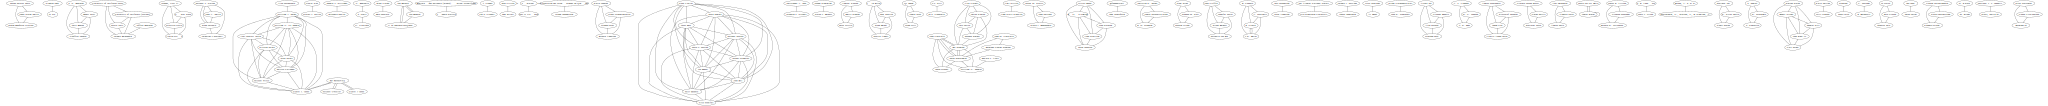

In [20]:
%%dot -f svg
graph {
		"Susana Pajares Tosca" -- "Simon Egenfeldt-Nielsen"
		"Susana Pajares Tosca" -- "Jonas Heide Smith"
		"Jonas Heide Smith" -- "Simon Egenfeldt-Nielsen"
		"Xingcan Chen" -- "Li Liu"
		"F. N. Robinson" -- "Geoffrey Chaucer"
		"F. N. Robinson" -- "Larry Benson"
		"F. N. Robinson" -- "Robert Pratt"
		"Robert Pratt" -- "Geoffrey Chaucer"
		"Robert Pratt" -- "Larry Benson"
		"Larry Benson" -- "Geoffrey Chaucer"
		"University of California Press" -- "Jerome Rothenberg"
		"University of California Press" -- "Pierre Joris"
		"University of California Press" -- "University of California (System)"
		"University of California (System)" -- "Jerome Rothenberg"
		"University of California (System)" -- "Pierre Joris"
		"Pierre Joris" -- "Jerome Rothenberg"
		" Wagner, Gert G." -- "Adrian Duşa"
		" Wagner, Gert G." -- "Dietrich Nelle"
		" Wagner, Gert G." -- "Günter Stock"
		"Günter Stock" -- "Adrian Duşa"
		"Günter Stock" -- "Dietrich Nelle"
		"Dietrich Nelle" -- "Adrian Duşa"
		"Michael L. Nelson" -- "Frank McCown"
		"Michael L. Nelson" -- "Joan A. Smith"
		"Joan A. Smith" -- "Frank McCown"
		"Roy Rosenzweig" -- "Daniel J. Cohen"
		"Jiawei Han" -- "Harvey J. Miller"
		"Thomas C. Stillinger" -- "Elizabeth Fowler"
		"G. Roncaglia" -- "F. Ciotti"
		"Elana Gainor" -- "Ruth Mostern"
		"Lou Burnard" -- "C. M Sperberg-McQueen"
		" Bibliothèque nationale (France). Éditeur scientifique" -- "Léopold Delisle"
		"A Geddes" -- "Ian N Gregory"
		"Sean Gillies" -- "Tom Elliott"
		"Śāntarakṣita" -- "Luis O Gómez"
		"Association des archéologues du Québec" -- "Claude Chapdelaine"
		"Keith Johnson" -- "Richard Anderson"
		"Keith Johnson" -- "Hannah Frost"
		"Keith Johnson" -- "Nancy Hoebelheinrich"
		"Nancy Hoebelheinrich" -- "Richard Anderson"
		"Nancy Hoebelheinrich" -- "Hannah Frost"
		"Hannah Frost" -- "Richard Anderson"
		"Noah Vawter" -- "Nick Montfort"
		"Noah Vawter" -- "Patsy Baudoin"
		"Noah Vawter" -- "John Bell"
		"Noah Vawter" -- "Ian Bogost"
		"Noah Vawter" -- "Jeremy Douglass"
		"Noah Vawter" -- "Mark C. Marino"
		"Noah Vawter" -- "Michael Mateas"
		"Noah Vawter" -- "Casey Reas"
		"Noah Vawter" -- "Mark Sample"
		"Mark Sample" -- "Nick Montfort"
		"Mark Sample" -- "Patsy Baudoin"
		"Mark Sample" -- "John Bell"
		"Mark Sample" -- "Ian Bogost"
		"Mark Sample" -- "Jeremy Douglass"
		"Mark Sample" -- "Mark C. Marino"
		"Mark Sample" -- "Michael Mateas"
		"Mark Sample" -- "Casey Reas"
		"Casey Reas" -- "Nick Montfort"
		"Casey Reas" -- "Patsy Baudoin"
		"Casey Reas" -- "John Bell"
		"Casey Reas" -- "Ian Bogost"
		"Casey Reas" -- "Jeremy Douglass"
		"Casey Reas" -- "Mark C. Marino"
		"Casey Reas" -- "Michael Mateas"
		"Michael Mateas" -- "Nick Montfort"
		"Michael Mateas" -- "Patsy Baudoin"
		"Michael Mateas" -- "John Bell"
		"Michael Mateas" -- "Ian Bogost"
		"Michael Mateas" -- "Jeremy Douglass"
		"Michael Mateas" -- "Mark C. Marino"
		"Mark C. Marino" -- "Nick Montfort"
		"Mark C. Marino" -- "Patsy Baudoin"
		"Mark C. Marino" -- "John Bell"
		"Mark C. Marino" -- "Ian Bogost"
		"Mark C. Marino" -- "Jeremy Douglass"
		"Jeremy Douglass" -- "Nick Montfort"
		"Jeremy Douglass" -- "Patsy Baudoin"
		"Jeremy Douglass" -- "John Bell"
		"Jeremy Douglass" -- "Ian Bogost"
		"Ian Bogost" -- "Nick Montfort"
		"Ian Bogost" -- "Patsy Baudoin"
		"Ian Bogost" -- "John Bell"
		"John Bell" -- "Nick Montfort"
		"John Bell" -- "Patsy Baudoin"
		"Patsy Baudoin" -- "Nick Montfort"
		"Christopher A. Pool" -- "Deborah L. Nichols"
		"Jeanne Hamming" -- "Helen J. Burgess"
		"Andrew Kenyon" -- "Peter Hirtle"
		"Andrew Kenyon" -- "Emily Hudson"
		"Emily Hudson" -- "Peter Hirtle"
		"Jörg Ritter" -- "Martin Andert"
		"Jörg Ritter" -- "Frank Berger"
		"Jörg Ritter" -- "Paul Molitor"
		"Paul Molitor" -- "Martin Andert"
		"Paul Molitor" -- "Frank Berger"
		"Frank Berger" -- "Martin Andert"
		"Qi Zheng" -- "Linda Hill"
		"Qi Zheng" -- "James Frew"
		"James Frew" -- "Linda Hill"
		"L.L. Hill" -- "M.F. Goodchild"
		"Roy Rosenzweig" -- "Daniel J. Cohen"
		"John M. Unsworth" -- "Susan Schreibman"
		"John M. Unsworth" -- "Raymond George Siemens"
		"Raymond George Siemens" -- "Susan Schreibman"
		"Amy Hillier" -- "Anne Kelly Knowles"
		"Trevor M. Harris" -- "David J. Bodenhamer"
		"Trevor M. Harris" -- "John Corrigan"
		"John Corrigan" -- "David J. Bodenhamer"
		"Roy Rosenzweig" -- "Daniel J Cohen"
		"Olivia Rohan" -- "Mike Cosgrave"
		"Olivia Rohan" -- "Anna Dowling"
		"Olivia Rohan" -- "Lynn Harding"
		"Olivia Rohan" -- "Róisín O'Brien"
		"Róisín O'Brien" -- "Mike Cosgrave"
		"Róisín O'Brien" -- "Anna Dowling"
		"Róisín O'Brien" -- "Lynn Harding"
		"Lynn Harding" -- "Mike Cosgrave"
		"Lynn Harding" -- "Anna Dowling"
		"Anna Dowling" -- "Mike Cosgrave"
		"Roy Rosenzweig" -- "Daniel J Cohen"
		"Syd Bauman" -- "C. M Sperberg-McQueen"
		"Syd Bauman" -- "Lou Burnard"
		"Lou Burnard" -- "C. M Sperberg-McQueen"
		"Lou Burnard" -- "Syd Bauman"
		" @foundhistory" -- "Tom Scheinfeldt"
		"Christian K. Zacher" -- "R. W. Hanning"
		"Christian K. Zacher" -- "James McMurrin Dean"
		"James McMurrin Dean" -- "R. W. Hanning"
		"Liam Frink" -- "Maxine Oland"
		"Liam Frink" -- "Siobhan M. Hart"
		"Siobhan M. Hart" -- "Maxine Oland"
		"Joan Griffin" -- "Michelle van Ryn"
		"Joan Griffin" -- "Diana Burgess"
		"Joan Griffin" -- "Jennifer Malat"
		"Jennifer Malat" -- "Michelle van Ryn"
		"Jennifer Malat" -- "Diana Burgess"
		"Diana Burgess" -- "Michelle van Ryn"
		"R. Grusin" -- "J.D. Bolter"
		"Tara McPherson" -- "Steve Anderson"
		"Frank McCown" -- "Michael L. Nelson"
		"Frank McCown" -- "Catherine C Marshall"
		"Catherine C Marshall" -- "Michael L. Nelson"
		" Los Alamos National Library" -- " Old Dominion University"
		"Jerome J. McGann" -- "James Soderholm"
		"Nate Schweber" -- "Al Baker"
		"Diane Goldenberg-Hart" -- "Joan K. Lippincott"
		"Archie Tse" -- "Haeyoun Park"
		"Archie Tse" -- "Alan McLean"
		"Archie Tse" -- "Graham Roberts"
		"Graham Roberts" -- "Haeyoun Park"
		"Graham Roberts" -- "Alan McLean"
		"Alan McLean" -- "Haeyoun Park"
		"A. L. Vaughan" -- "C. H. Epps"
		"A. L. Vaughan" -- "D. G. Johnson"
		"D. G. Johnson" -- "C. H. Epps"
		"Andrea Scharnhorst" -- "Almila Akdag Salah"
		"Andrea Scharnhorst" -- "Cheng Gao"
		"Andrea Scharnhorst" -- "Krzysztof Suchecki"
		"Krzysztof Suchecki" -- "Almila Akdag Salah"
		"Krzysztof Suchecki" -- "Cheng Gao"
		"Cheng Gao" -- "Almila Akdag Salah"
		"Giorgio Tavano Blessi" -- "Pierluigi Sacco"
		"Giorgio Tavano Blessi" -- "Guido Ferilli"
		"Guido Ferilli" -- "Pierluigi Sacco"
		"Amy Bruckman" -- "Andrea Forte"
		"Amy Bruckman" -- "Vanessa Larco"
		"Vanessa Larco" -- "Andrea Forte"
		"Maria Pia Di Bella" -- "James Elkins"
		"Maria Pia Di Bella" -- "James Elkins"
		"James Elkins" -- "James Elkins"
		"James R. Allison" -- "Richard H. Wilshusen"
		"James R. Allison" -- "Gregson Schachner"
		"Gregson Schachner" -- "Richard H. Wilshusen"
		"Alex Garnett" -- "Ray Siemens"
		"Alex Garnett" -- "Meagan Timney"
		"Alex Garnett" -- "Cara Leitch"
		"Alex Garnett" -- "Corina Koolen"
		"Corina Koolen" -- "Ray Siemens"
		"Corina Koolen" -- "Meagan Timney"
		"Corina Koolen" -- "Cara Leitch"
		"Cara Leitch" -- "Ray Siemens"
		"Cara Leitch" -- "Meagan Timney"
		"Meagan Timney" -- "Ray Siemens"
		"S. B. Adonʹeva" -- "Laura J. Olson"
		"Bishop, A. P. et al." -- "Marchionini, G., Plaisant, C., & Komlodi, A."
		"Alan MacEachern" -- "William J. Turkel"
		"Matthew Loy" -- "Nancy Maron"
		"Matthew Loy" -- "K. Kirby Smith"
		"K. Kirby Smith" -- "Nancy Maron"
		"John Unsworth" -- "William G. Thomas"
		"John Unsworth" -- "Susan Schreibman"
		"John Unsworth" -- "Ray Siemens"
		"Ray Siemens" -- "William G. Thomas"
		"Ray Siemens" -- "Susan Schreibman"
		"Susan Schreibman" -- "William G. Thomas"
		"Jeffrey Robinson" -- "Jerome Rothenberg"
		"F. Tomasi" -- "T. Numerico"
		"F. Tomasi" -- "D. Fiormonte"
		"D. Fiormonte" -- "T. Numerico"
		"Roy Rosenzweig" -- "Michael O'Malley"
		"Dursun Delen" -- "Gary Miner"
		"Dursun Delen" -- "John Elder IV"
		"Dursun Delen" -- "Thomas Hill"
		"Dursun Delen" -- "Robert Nisbet"
		"Robert Nisbet" -- "Gary Miner"
		"Robert Nisbet" -- "John Elder IV"
		"Robert Nisbet" -- "Thomas Hill"
		"Thomas Hill" -- "Gary Miner"
		"Thomas Hill" -- "John Elder IV"
		"John Elder IV" -- "Gary Miner"
		"Katie Shilton" -- "Lilly Nguyen"
		"B. Gennaro" -- "J.D. Bolter"
		"B. Gennaro" -- "R. Grusin"
		"B. Gennaro" -- "A. Marinelli"
		"A. Marinelli" -- "J.D. Bolter"
		"A. Marinelli" -- "R. Grusin"
		"R. Grusin" -- "J.D. Bolter"
		" Demand" -- "Fabio Ciracì"
		"F. Ciotti" -- "G. Gigliozzi"
		"V. Marangi" -- "R. Baroncelli"
		"Jo Walsh" -- "Schuyler Erle"
		"Jo Walsh" -- "Rich Gibson"
		"Rich Gibson" -- "Schuyler Erle"
		"Seb Chan" -- "Susan Cairns"
		"John Unsworth" -- "Susan Hockey"
		"John Unsworth" -- "Susan Schreibman"
		"John Unsworth" -- "Ray Siemens"
		"Ray Siemens" -- "Susan Hockey"
		"Ray Siemens" -- "Susan Schreibman"
		"Susan Schreibman" -- "Susan Hockey"
		"George Michalopoulos" -- "Kenneth Dyson"
		"George Michalopoulos" -- "Kevin Featherstone"
		"Kevin Featherstone" -- "Kenneth Dyson"
		"W. R Trask" -- "M. Eliade"
		"Matthew J. L. Connolly" -- " Davis, Philip M."
		"William J. Turkel" -- "Daniel J. Cohen"
		"William J. Turkel" -- "Michael Frisch"
		"William J. Turkel" -- "Patrick Gallagher"
		"William J. Turkel" -- "Steve Mintz"
		"William J. Turkel" -- "Kirsten Sword"
		"William J. Turkel" -- "Amy Murrell Taylor"
		"William J. Turkel" -- "William G. III Thomas"
		"William G. III Thomas" -- "Daniel J. Cohen"
		"William G. III Thomas" -- "Michael Frisch"
		"William G. III Thomas" -- "Patrick Gallagher"
		"William G. III Thomas" -- "Steve Mintz"
		"William G. III Thomas" -- "Kirsten Sword"
		"William G. III Thomas" -- "Amy Murrell Taylor"
		"Amy Murrell Taylor" -- "Daniel J. Cohen"
		"Amy Murrell Taylor" -- "Michael Frisch"
		"Amy Murrell Taylor" -- "Patrick Gallagher"
		"Amy Murrell Taylor" -- "Steve Mintz"
		"Amy Murrell Taylor" -- "Kirsten Sword"
		"Kirsten Sword" -- "Daniel J. Cohen"
		"Kirsten Sword" -- "Michael Frisch"
		"Kirsten Sword" -- "Patrick Gallagher"
		"Kirsten Sword" -- "Steve Mintz"
		"Steve Mintz" -- "Daniel J. Cohen"
		"Steve Mintz" -- "Michael Frisch"
		"Steve Mintz" -- "Patrick Gallagher"
		"Patrick Gallagher" -- "Daniel J. Cohen"
		"Patrick Gallagher" -- "Michael Frisch"
		"Michael Frisch" -- "Daniel J. Cohen"
		"Edward L. Ayers" -- "William G. Thomas"
		"Roy Rosenzweig" -- "Michael O'Malley"
		"Dave Weissman" -- "Raymond Lo"
		"Dave Weissman" -- "Guhan Viswanathan"
		"Guhan Viswanathan" -- "Raymond Lo"
}